In [1]:
import os

os.makedirs('opt' , exist_ok=True)
os.chdir( 'opt' )
!git clone 'https://github.com/cocodataset/cocoapi.git'

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 28.38 MiB/s, done.
Resolving deltas: 100% (576/576), done.


zip removed
zip removed
instances_val2014.json
loading annotations into memory...
Done (t=5.89s)
creating index...
index created!
loading annotations into memory...
Done (t=0.39s)
creating index...
index created!
http://images.cocodataset.org/val2014/COCO_val2014_000000003934.jpg
Number of annotations i.e captions for the image:  [288276, 290376, 290448, 291276, 293766]

A young girl in the foreground and a woman in a bridal dress and other adults in the background. 
A young girl holding a controller playing a video game.
A young girl playing a video game while others talk.
A little girl holding a white Nintendo Wii game controller.
A blurry photo of a girl concentrating next to what seems like party goers.
zip removed
zip removed


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


loading annotations into memory...
Done (t=1.04s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=0.70s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:50<00:00, 8213.33it/s]


Find Below the Sample tokens and the idx values of those tokens in word2idx 

['<start>', 'a', 'person', 'doing', 'a', 'trick', 'xxxx', 'on', 'a', 'rail', 'while', 'riding', 'a', 'skateboard', '.', '<end>']
tensor([  0,   3,  97, 744,   3, 393,   2,  38,   3, 993, 205, 137,   3, 743,
         18,   1])
Find index values for words below 

Start idx 0 , End idx 1 , unknown idx 2
First few vocab {'<start>': 0, '<end>': 1, '<unk>': 2, 'a': 3, 'very': 4, 'clean': 5, 'and': 6, 'well': 7, 'decorated': 8, 'empty': 9}
Total number of tokens in vocabulary: 7072
value 10  count 86302
value 11  count 79971
value  9  count 71920
value 12  count 57653
value 13  count 37668
value 14  count 22342
value  8  count 20742
value 15  count 12839
value 16  count  7736
Sample Indices: [344091, 283222, 401768, 17670, 172964, 32566, 177511, 252283, 289278, 211451, 123128, 346998, 215304, 90977, 18374, 346022, 84435, 154988, 288798, 262775, 293609, 389322, 402891, 116718, 225045, 62997, 128393, 367504, 293948, 3

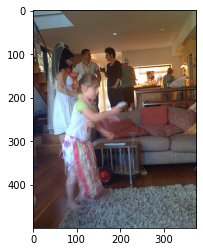

In [2]:
from data import data_related

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import math

In [ ]:
class Encoder(nn.Module):
    def __init__(self, embed_size):
        super(Encoder, self).__init__()
        self.net = models.resnet50(pretrained = True)
        self.net.fc = nn.Linear(2048, embed_size)
        for parameter in self.net.parameters():
          parameter.requires_grad = False
        for parameter in self.net.fc.parameters():
          parameter.requires_grad = True

    def forward(self, images):
        features = self.net(images)
        return features

In [ ]:
class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(Decoder, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size 
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.embedding_layer = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embed_size)
        self.lstm_decoder = nn.LSTM(input_size=self.embed_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True )
        self.fc = nn.Linear(self.hidden_size, self.vocab_size)

    def init_hidden(self, batch_size):
        return ( torch.zeros( self.num_layers , batch_size , self.hidden_size  ).to(device),
        torch.zeros( self.num_layers , batch_size , self.hidden_size  ).to(device) )
    
    def forward(self, features, captions):            
        captions = captions[:,  :-1]      
        self.batch_size = features.shape[0]
        self.hidden = self.init_hidden( self.batch_size )
        outputs = None  
        
        embedded_words = self.embedding_layer(captions)
        lstm_outputs, self.hidden = self.lstm_decoder(torch.cat((features.unsqueeze(dim=1), embedded_words), dim=1), self.hidden)
        outputs = self.fc(lstm_outputs)

        return outputs

    def generate(self, inputs, max_len=20):
        final_output = []
        batch_size = inputs.shape[0]         
        hidden = self.init_hidden(batch_size)
        max_sent_length = 20
    
        while len(final_output) <= max_sent_length:
          lstm_out, hidden = self.lstm_decoder(inputs, hidden) 
          outputs = self.fc(lstm_out)

          maximum_out = torch.max(outputs.squeeze(1) , dim=1) 
          final_output.append(maximum_out[1].cpu().numpy()[0].item())   

          if maximum_out[1] == 1:
              break  

          inputs = self.embedding_layer(maximum_out[1]).unsqueeze(1)

        return final_output  


In [ ]:
embed_size = 256
hidden_size = 100
num_layers =1 
num_epochs = 4
print_every = 150
save_every = 1
vocab_size = len(data_related.data_loader_train.dataset.vocab)
total_step = math.ceil(len(data_related.data_loader_train.dataset.caption_lengths) / 
                       data_related.data_loader_train.batch_sampler.batch_size)
lr = 0.001
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_save_path = 'model_weights/'
os.makedirs( model_save_path , exist_ok=True)

encoder = Encoder(embed_size)
decoder = Decoder(embed_size, hidden_size, vocab_size ,num_layers)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=list(encoder.net.fc.parameters()) + list(decoder.parameters()), lr=lr)

In [ ]:
import sys
encoder.train()
decoder.train()
for e in range(1, num_epochs):
    for step in range(total_step):
        indices = data_related.data_loader_train.dataset.get_train_indices()
        new_sampler = data_related.data.sampler.SubsetRandomSampler(indices)
        data_related.data_loader_train.batch_sampler.sampler = new_sampler    
        images,captions = next(iter(data_related.data_loader_train))    
        images , captions = images.to(device) , captions.to(device)
        encoder , decoder = encoder.to(device) , decoder.to(device)
        encoder.zero_grad()    
        decoder.zero_grad()
        
        encoder_outputs = encoder(images)
        decoder_outputs = decoder(encoder_outputs, captions)
        loss = criterion(decoder_outputs.view(-1, vocab_size), captions.view(-1))

        loss.backward()
        optimizer.step()
        stat_vals = 'Epochs [%d/%d] Step [%d/%d] Loss [%.4f] ' %(e+1, num_epochs, step, total_step,loss.item())
        if step % print_every == 0:
            print(stat_vals)
            sys.stdout.flush()
            torch.save( encoder.state_dict() ,  os.path.join( model_save_path , 'encoderdata_{}.pkl'.format(e+1) ) )
            torch.save( decoder.state_dict() ,  os.path.join( model_save_path , 'decoderdata_{}.pkl'.format(e+1) ) )
    if e % save_every == 0:
        torch.save( encoder.state_dict() ,  os.path.join( model_save_path , 'encoderdata_{}.pkl'.format(e+1) ) )
        torch.save( decoder.state_dict() ,  os.path.join( model_save_path , 'decoderdata_{}.pkl'.format(e+1) ) )

Epochs [2/4] Step [0/2071] Loss [8.6253] 
Epochs [2/4] Step [150/2071] Loss [4.0115] 
Epochs [2/4] Step [300/2071] Loss [3.7721] 
Epochs [2/4] Step [450/2071] Loss [3.3129] 
Epochs [2/4] Step [600/2071] Loss [3.2426] 
Epochs [2/4] Step [750/2071] Loss [3.2920] 
Epochs [2/4] Step [900/2071] Loss [3.0368] 
Epochs [2/4] Step [1050/2071] Loss [2.9906] 
Epochs [2/4] Step [1200/2071] Loss [3.5733] 
Epochs [2/4] Step [1350/2071] Loss [3.0126] 
Epochs [2/4] Step [1500/2071] Loss [2.8783] 
Epochs [2/4] Step [1650/2071] Loss [2.8729] 
Epochs [2/4] Step [1800/2071] Loss [2.6964] 
Epochs [2/4] Step [1950/2071] Loss [2.7208] 
Epochs [3/4] Step [0/2071] Loss [2.6909] 
Epochs [3/4] Step [150/2071] Loss [2.7300] 
Epochs [3/4] Step [300/2071] Loss [2.7177] 
Epochs [3/4] Step [450/2071] Loss [2.5092] 
Epochs [3/4] Step [600/2071] Loss [2.5541] 
Epochs [3/4] Step [750/2071] Loss [2.4640] 
Epochs [3/4] Step [900/2071] Loss [2.4420] 
Epochs [3/4] Step [1050/2071] Loss [2.4751] 
Epochs [3/4] Step [1200/2071

In [ ]:
checkpoint_decoder = torch.load('decoderdata_4.pkl', map_location=torch.device('cpu'))
decoder.load_state_dict(checkpoint_decoder)

checkpoint_encoder = torch.load('encoderdata_4.pkl', map_location=torch.device('cpu'))
encoder.load_state_dict(checkpoint_encoder)

<All keys matched successfully>

'a clock tower with a clock on the top of it .'

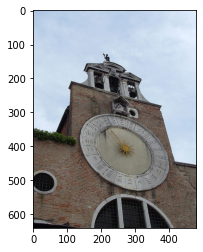

In [ ]:
encoder.to(device)
decoder.to(device)
encoder.eval()
decoder.eval()
original_img , processed_img  = next( data_related.data_iter )

features  = encoder(processed_img.to(device)).unsqueeze(1)
final_output = decoder.generate( features  , max_len=20)
data_related.get_sentences(original_img, final_output)